## import libraries 

In [24]:
import warnings
warnings.filterwarnings('ignore')

import os

from siml.sk_utils import *
from siml.signal_analysis_utils import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from collections import defaultdict, Counter
import scipy.stats
import pywt
import datetime as dt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import welch

## Methods to calculate characteristics of signals

### Fast Fourier Transform (FFT) 

In [3]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

Let's take five sine-waves (blue signals) with amplitudes 4, 6, 8, 10 and 14 and frequencies 6.5, 5, 3, 1.5 and 1 Hz. By combining these signals we can form a new composite signal (black). The Fourier Transform transforms this signal to the frequency-domain (red signal) and shows us at which frequencies the component signals oscillate. 

IndexError: list index out of range

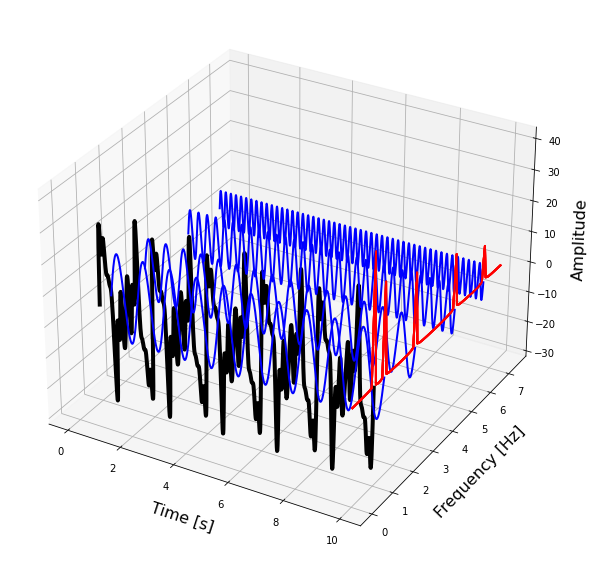

In [4]:
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

x_value = np.linspace(0,t_n,N)
amplitudes = [4, 6, 8, 10, 14]
frequencies = [6.5, 5, 3, 1.5, 1]
y_values = [amplitudes[ii]*np.sin(2*np.pi*frequencies[ii]*x_value) for ii in range(0,len(amplitudes))]
composite_y_value = np.sum(y_values, axis=0)

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

colors = ['k', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("\nTime [s]", fontsize=16)
ax.set_ylabel("\nFrequency [Hz]", fontsize=16)
ax.set_zlabel("\nAmplitude", fontsize=16)

y_values_ = [composite_y_value] + list(reversed(y_values))
frequencies = [1, 1.5, 3, 5, 6.5]

for ii in range(0,len(y_values_)):
    signal = y_values_[ii]
    color = colors[ii]
    length = signal.shape[0]
    x=np.linspace(0,10,1000)
    y=np.array([frequencies[ii]]*length)
    z=signal

    if ii == 0:
        linewidth = 4
    else:
        linewidth = 2
    ax.plot(list(x), list(y), zs=list(z), linewidth=linewidth, color=color)

    x=[10]*75
    y=f_values[:75]
    z = fft_values[:75]*3
    ax.plot(list(x), list(y), zs=list(z), linewidth=2, color='red')
    
    plt.tight_layout()
plt.show()

#### calculate the FFT of the composite signal above, and retrieve the frequency values of its component signals.

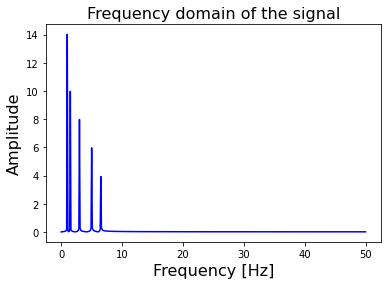

In [5]:
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

f_values, fft_values = get_fft_values(composite_y_value, T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

### Power Spectral Density 

Similar to the FFT, it describes the frequency spectrum of a signal. But in addition to the FFT it also takes the power distribution at each frequency (bin) into account. 

In [6]:
def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

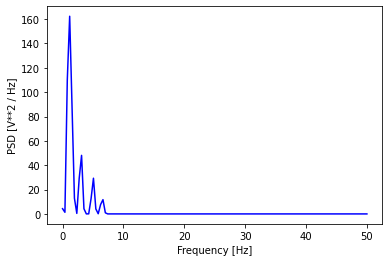

In [7]:
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

f_values, psd_values = get_psd_values(composite_y_value, T, N, f_s)

plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

###  calculates the correlation of a signal with a time-delayed version of itself 

In [8]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

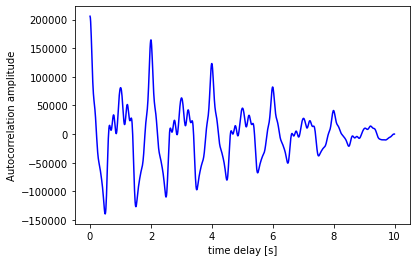

In [9]:
t_n = 10
N = 1000
T = t_n / N
f_s = 1/T

t_values, autocorr_values = get_autocorr_values(composite_y_value, T, N, f_s)

plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

### Wavelet Transform

It transform a signal into its frequency domain, just like the Fourier Transform.

The difference is: the Fourier Transform has a very high resolution in the frequency domain, and zero resolution in the time domain; we know at which frequencies the signal oscillates, but not at which time these oscillations occur. The output of a Wavelet transform hash a high resolution in the frequency domain and also in the time domain; it maintains information about the time-domain.

In [22]:
def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    return yticks, ylim

    
def get_ave_values(xvalues, yvalues, n = 5):
    signal_length = len(xvalues)
    if signal_length % n == 0:
        padding_length = 0
    else:
        padding_length = n - signal_length//n % n
    xarr = np.array(xvalues)
    yarr = np.array(yvalues)
    xarr.resize(signal_length//n, n)
    yarr.resize(signal_length//n, n)
    xarr_reshaped = xarr.reshape((-1,n))
    yarr_reshaped = yarr.reshape((-1,n))
    x_ave = xarr_reshaped[:,0]
    y_ave = np.nanmean(yarr_reshaped, axis=1)
    return x_ave, y_ave

   
def plot_signal_plus_average(ax, time, signal, average_over = 5):
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], time[-1]])
    ax.set_ylabel('Amplitude', fontsize=16)
    ax.set_title('Signal + Time Average', fontsize=16)
    ax.legend(loc='upper right')
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(ax, time, signal, plot_direction='horizontal', yticks=None, ylim=None):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2
    if plot_direction == 'horizontal':
        ax.plot(f_values, fft_values, 'r-', label='Fourier Transform')
        ax.plot(f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    elif plot_direction == 'vertical':
        scales = 1./f_values
        scales_log = np.log2(scales)
        ax.plot(fft_values, scales_log, 'r-', label='Fourier Transform')
        ax.plot(fft_power, scales_log, 'k--', linewidth=1, label='FFT Power Spectrum')
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        ax.invert_yaxis()
        ax.set_ylim(ylim[0], -1)
    ax.legend()

dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
df_nino = pd.read_table(dataset)
N = df_nino.shape[0]
t0=1871
dt=0.25
time = np.arange(0, N) * dt + t0
signal = df_nino.values.squeeze()


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


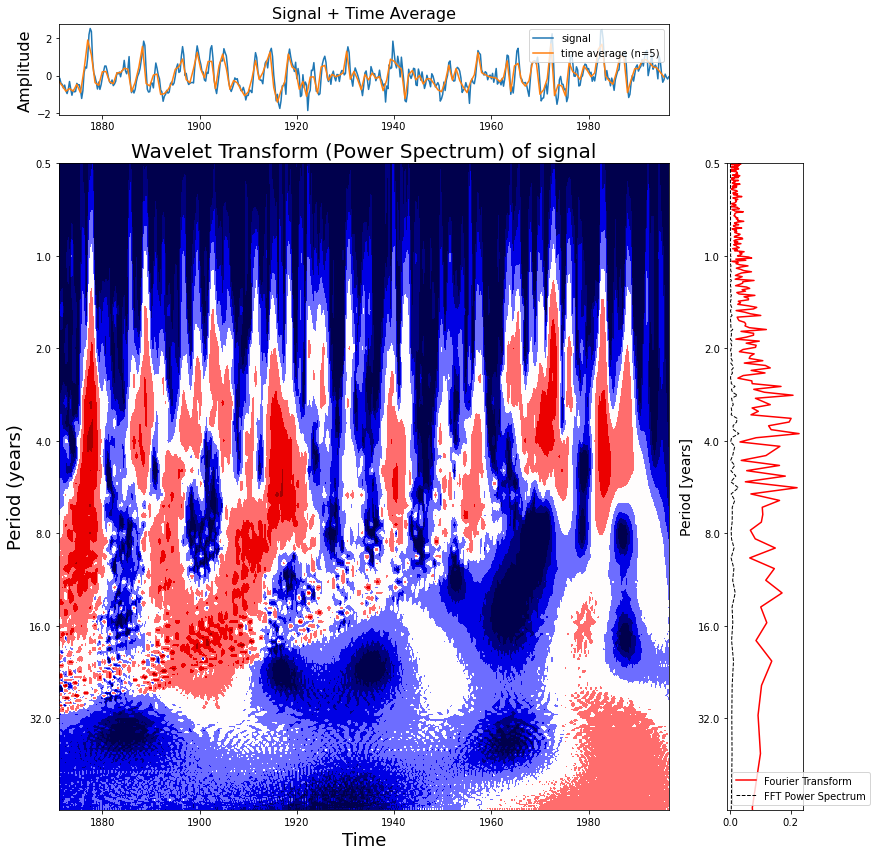

In [23]:
fig = plt.figure(figsize=(12,12))
spec = gridspec.GridSpec(ncols=6, nrows=6)
top_ax = fig.add_subplot(spec[0, 0:5])
bottom_left_ax = fig.add_subplot(spec[1:, 0:5])
bottom_right_ax = fig.add_subplot(spec[1:, 5])

title = 'Wavelet Transform (Power Spectrum) of signal'
ylabel = 'Period (years)'
xlabel = 'Time'

plot_signal_plus_average(top_ax, time, signal, average_over = 3)
yticks, ylim = plot_wavelet(bottom_left_ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)

plot_fft_plus_power(bottom_right_ax, time, signal, plot_direction='vertical', yticks=yticks, ylim=ylim)
bottom_right_ax.set_ylabel('Period [years]', fontsize=14)
plt.tight_layout()
plt.show()

## Classification of Human Activity 

Human Activity Recognition Using Smartphones Data Set contains measurements done by 30 people between the ages of 19 to 48. The measurements are done with a smartphone placed on the waist while doing one of the following six activities:

1. walking,
2. walking upstairs,
3. walking downstairs,
4. sitting,
5. standing or
6. laying.

### Loading signals from raw dataset (Human Activation Recognition (HAR))

In [20]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

### Prepared dataset

In [54]:
INPUT_FOLDER_TRAIN = '../data/raw/UCI_HAR_Dataset/train/Inertial Signals/'
INPUT_FOLDER_TEST = '../data/raw/UCI_HAR_Dataset/test/Inertial Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = '../data/raw/UCI_HAR_Dataset/train/y_train.txt'
LABELFILE_TEST = '../data/raw/UCI_HAR_Dataset/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))


for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train dataset contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The test dataset contains {} signals, each one of length {} and {} components ".format(no_signals_test, no_steps_test, no_components_test))
print("The train dataset contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print("The test dataset contains {} labels, with the following distribution:\n {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

SAVE_FOLDER_TRAIN = '../data/processed/UCI_HAR_Dataset/train/Inertial Signals/'
SAVE_FOLDER_TEST = '../data/processed/UCI_HAR_Dataset/test/Inertial Signals/'

if not os.path.exists(SAVE_FOLDER_TRAIN):
    os.makedirs(SAVE_FOLDER_TRAIN)

if not os.path.exists(SAVE_FOLDER_TEST):
    os.makedirs(SAVE_FOLDER_TEST)
    
with open(SAVE_FOLDER_TRAIN + 'train_signals.npy', 'wb') as f_train:
    np.save(f_train, train_signals)
with open(SAVE_FOLDER_TRAIN + 'train_labels.npy', 'wb') as f_train:
    np.save(f_train, train_labels)
with open(SAVE_FOLDER_TEST + 'test_signals.npy', 'wb') as f_test:
    np.save(f_test, test_signals)
with open(SAVE_FOLDER_TEST + 'test_labels.npy', 'wb') as f_test:
    np.save(f_test, test_labels)

The train dataset contains 7352 signals, each one of length 128 and 9 components 
The test dataset contains 2947 signals, each one of length 128 and 9 components 
The train dataset contains 7352 labels, with the following distribution:
 Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
The test dataset contains 2947 labels, with the following distribution:
 Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})


### visualize the signal itself with its nine components, the FFT, the PSD and auto-correlation of the components, together with the peaks present in each of the three transformations.

C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\scipy\signal\spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_leng

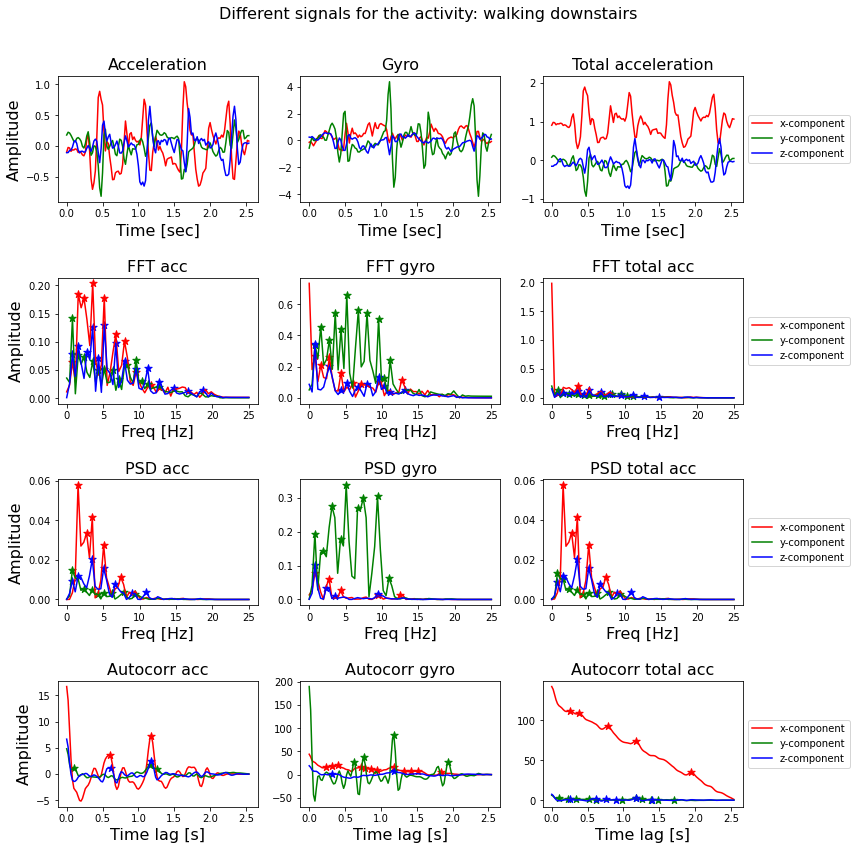

In [61]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

####
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]


N = 128
f_s = 50
t_n = 2.56
T = t_n / N
sample_rate = 1 / f_s
denominator = 10

signal_no = 15
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]


f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

## Extract features from all signals in the training and test set 

In [74]:
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

def calculate_statistics(list_values):
    n5 = np.nanpercentile(list_values, 5)
    n25 = np.nanpercentile(list_values, 25)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

def get_ecs_features(list_values):
    entropy = calculate_entropy(list_values)
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    return [entropy] + crossings + statistics

def get_wavelet_features(dataset, labels, waveletname):
    uci_har_features = []
    for signal_no in range(0, len(dataset)):
        features = []
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            list_coeff = pywt.wavedec(signal, waveletname)
            for coeff in list_coeff:
                features += get_ecs_features(coeff)
        uci_har_features.append(features)
    X = np.array(uci_har_features)
    Y = np.array(labels)
    return X, Y


def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
            list_coeff = pywt.wavedec(signal, 'rbio3.1')
            for coeff in list_coeff:
                features += get_ecs_features(coeff)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

denominator = 10
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

## Classifying the train and test sets

In [75]:
dict_classifiers = {
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear SVM": SVC(),
    "Neural Net": MLPClassifier(alpha = 1),
    "Naive Bayes": GaussianNB(),   
    "AdaBoost": AdaBoostClassifier(),
    "Gaussian Process": GaussianProcessClassifier()
}
   
def batch_classify(X_train, Y_train, X_test, Y_test, no_classifiers = 5, verbose = True):
    """
    This method, takes as input the X, Y matrices of the Train and Test set.
    And fits them on all of the Classifiers specified in the dict_classifier.
    Usually, the SVM, Random Forest and Gradient Boosting Classifier take quiet some time to train. 
    So it is best to train them on a smaller dataset first and 
    decide whether you want to comment them out or not based on the test accuracy score.
    """
    
    dict_models = {}
    for classifier_name, classifier in list(dict_classifiers.items())[:no_classifiers]:
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()
        
        t_diff = t_end - t_start
        train_score = classifier.score(X_train, Y_train)
        test_score = classifier.score(X_test, Y_test)
        
        dict_models[classifier_name] = {'model': classifier, 'train_score': train_score, 'test_score': test_score, 'train_time': t_diff}
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=classifier_name, f=t_diff))
    return dict_models

def display_dict_models(dict_models, sort_by='test_score'):
    cls = [key for key in dict_models.keys()]
    test_s = [dict_models[key]['test_score'] for key in cls]
    training_s = [dict_models[key]['train_score'] for key in cls]
    training_t = [dict_models[key]['train_time'] for key in cls]
    
    df_ = pd.DataFrame(data=np.zeros(shape=(len(cls),4)), columns = ['classifier', 'train_score', 'test_score', 'train_time'])
    for ii in range(0,len(cls)):
        df_.loc[ii, 'classifier'] = cls[ii]
        df_.loc[ii, 'train_score'] = training_s[ii]
        df_.loc[ii, 'test_score'] = test_s[ii]
        df_.loc[ii, 'train_time'] = training_t[ii]
    
    display(df_.sort_values(by=sort_by, ascending=False))
    

In [76]:
models = batch_classify(X_train, Y_train, X_test, Y_test)
display_dict_models(models)

C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Gradient Boosting Classifier in 1214.84 s


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Random Forest in 13.43 s


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instea

trained Logistic Regression in 3.08 s


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Nearest Neighbors in 2.12 s


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


trained Decision Tree in 6.82 s


C:\ProgramData\Anaconda3\envs\spt\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


,classifier,train_score,test_score,train_time
0,Gradient Boosting Classifier,1.000000,0.953512,1214.838132
1,Random Forest,1.000000,0.934849,13.427121
2,Logistic Regression,0.967356,0.921276,3.079304
4,Decision Tree,1.000000,0.862911,6.823370
3,Nearest Neighbors,0.957155,0.849678,2.123766


In [34]:
import torch
import torch.nn as nn
from torch.nn import Conv1d, Conv2d, Sequential, ModuleList, BatchNorm2d
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms

In [35]:
class HARDataLoader:
    def __init__(self, data_root):
        self.data_root = data_root
        
    def pre_operation(self, **kwargs):
        pass
    
    def post_operation(self, **kwargs):
        X = kwargs.get("X", None)
        y = kwargs.get("y", None)
        return X, y
       

    # load a single file as a numpy array
    def load_file(self, filepath):
        dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values

    # load a list of files into a 3D array of [samples, features, timesteps]
    def load_group(self, filenames, prefix=''):
        loaded = list()
        for name in filenames:
            data = self.load_file(prefix + name)
            loaded.append(data)
        
        # stack group and transpose to (samples, features, timesteps)
        loaded = np.dstack(loaded).transpose(0,2,1)
        return loaded

    # load a dataset group, such as train or test
    def load_dataset_group(self, group):
        filepath = os.path.join(self.data_root, group, 'Inertial Signals/')
        # load all 9 files as a single array
        filenames = list()
        # total acceleration
        filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
        # body acceleration
        filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
        # body gyroscope
        filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
        # load input data
        X = self.load_group(filenames, filepath)
        # load class output
        y = self.load_file(os.path.join(self.data_root, group, 'y_'+group+'.txt'))
        return X, y

    # load the dataset, returns train and test X and y elements
    def load_dataset(self, **kwargs):
        
        train_test = kwargs.get("train_test", "train")
        
        self.pre_operation(**kwargs)
        
        # load all train
        X, y = self.load_dataset_group(train_test)
        
        # zero-offset class values
        y = y - 1
        
        X, y = self.post_operation(X=X, y=y)
        
        return X, y
    
    def load_labels(self):
        labels_file = os.path.join(self.data_root, 'activity_labels.txt')
        return list(pd.read_csv(labels_file, header=None, delim_whitespace=True)[1].array)

    def to_categorical(self, y, num_classes):
        """ 1-hot encodes a tensor """
        return np.eye(num_classes, dtype='uint8')[y]
    
    # standardize data
    def scale_data(self, trainX, testX, standardize):
        # remove overlap
        cut = int(trainX.shape[1] / 2)
        longX = trainX[:, -cut:, :]
        # flatten windows
        longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
        # flatten train and test
        flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
        flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
        # standardize
        if standardize:
            s = StandardScaler()
            # fit on training data
            s.fit(longX)
            # apply to training and test data
            longX = s.transform(longX)
            flatTrainX = s.transform(flatTrainX)
            flatTestX = s.transform(flatTestX)
        # reshape
        flatTrainX = flatTrainX.reshape((trainX.shape))
        flatTestX = flatTestX.reshape((testX.shape))
        return flatTrainX, flatTestX

In [36]:
dl = HARDataLoader('../data/raw/UCI_HAR_Dataset')

# Load the dataset
train_X, train_y = dl.load_dataset(train_test='train') 
test_X, test_y = dl.load_dataset(train_test='test')


print("Training Data:", train_X.shape, train_y.shape)
print("Testing Data:", test_X.shape, test_y.shape)

Training Data: (7352, 9, 128) (7352, 1)
Testing Data: (2947, 9, 128) (2947, 1)


In [37]:
class HARDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.Transform = transform

    def __getitem__(self, index):
        x, y = self.X[index], self.y[index]
        if self.Transform:
            return self.Transform(x), y
        else:
            return x, y

    def __len__(self):
        return len(self.X)

In [38]:
# Create torch datasets and data loaders for train and test
train_set = HARDataset(train_X, train_y)
test_set = HARDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

print("Num Training samples: ", len(train_loader.dataset))
print("Num Testing samples:", len(test_loader.dataset))

Num Training samples:  7352
Num Testing samples: 2947


In [39]:
class Experiment:
    def __init__(self, config):
        self.config = config
        self.best_predictions = torch.empty(0)
        self.actuals = torch.empty(0)
        self.best_score = 0.0
        self.best_model = None
        self.labels=[]
        self.verbose = config.get("verbose", False)
        
        
    '''
        Function to update the config.
        Should be called by the experimenter is config needs to be 
        updated between experiment runs.
    '''
    def update_config(self, config):
        self.config = config
    
    '''
        Trains the network for n epochs and returns an accuracy score
    '''
    def train_and_evaluate(self, train_loader, test_loader):
        
        # If a random seed is set, weights, etc are initialised consistently 
        # between different runs.
        random_seed = self.config.get("random_seed", 0)
        if random_seed > 0:
            torch.manual_seed(random_seed)
        
        net_class = self.config.get("net_class", None)
        
        # We need the class name of the network to create dynamically.
        if net_class is None:
            print("net_class not supplied.")
            return
        
        # Create the net object from the class name. 
        net = globals()[net_class](self.config)
        
        if self.config.get("init_weights", False):
            # Initialise the network's weights
            net.apply(self.init_weights)
        
        # Get all the config parameters
        lr = self.config.get("lr", 0.01)
        batch_size = self.config.get("batch_size", 32)
        epochs = self.config.get("epochs_per_repeat",10)
        
        # Create the optimiser
        optimiser = optim.Adam(net.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        train_size = len(train_loader.dataset)
        for epoch in range(epochs):
            
            # Training
            
            net.train()
            correct = 0
            for X, y in train_loader:
                optimiser.zero_grad()
                X, y = X.float(), y.long().squeeze()
                
                out = net(X)
                if len(out) == 2:
                    y_hat, logits = out
                else:
                    y_hat, logits = out, out
                    
                loss = loss_fn(logits, y)
                loss.backward()
                optimiser.step()
                predicted = torch.argmax(y_hat.data,1)
                correct += (predicted == y).sum()

            acc_train = float(correct) * 100.0 / train_size
            if self.verbose:
                print("Train accuracy:", acc_train, "Loss: ", loss.item())
            
            # Interim Evaluation
            if epoch % 10 == 0:
                if self.verbose:
                    accuracy, actuals, predictions = self.evaluate(net, test_loader)
                    print("Testing accuracy: ", accuracy)
                
        # Final Evaluation
        accuracy, actuals, predictions = self.evaluate(net, test_loader)
        if accuracy > self.best_score:
            self.best_score = accuracy
            self.best_predictions = predictions
            self.best_model = net
            self.actuals = actuals
        return accuracy.item()

    
    def evaluate(self, net, test_loader):
        net.train(False)
        predictions = torch.empty(0)
        actuals = torch.empty(0)
        total_test_size = 0
        with torch.no_grad():
            correct = 0
            for X, y in test_loader:
                X, y = X.float(), y.long().squeeze()

                out = net(X)
                if len(out) == 2:
                    y_hat, logits = out
                else:
                    y_hat, logits = out, out

                predicted = torch.argmax(y_hat.data,1)
                predictions = torch.cat((predictions.float(), predicted.float()),0) 
                actuals = torch.cat((actuals.float(), y.float()), 0)
                total_test_size += y.size(0)
                correct += (predicted.numpy() == y.numpy()).sum()
        accuracy = correct * 100. / total_test_size
        return accuracy, actuals, predictions

    
    def init_weights(self, m):
        if type(m) in (nn.Linear, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
    
    '''
        summarize scores
    '''
    def summarize_results(self):
        m, s = np.mean(self.scores), np.std(self.scores)
        repeats = self.config.get("repeats", 10)
        print('Accuracy over {0} trials: {1:.3f}% (+/-{2:.3f})'.format(repeats, m, s))
        
        print('Best model accuracy: {0:.3f}%'.format(np.max(self.scores)))
        
        # confusion matrix for best scores
        conf_matrix = confusion_matrix(self.actuals, self.best_predictions)
        df_cm = pd.DataFrame(conf_matrix, index = self.labels, columns = self.labels)
        plt.figure(figsize = (3,3))
        plt.title('Confusion Matrix For Best Run', fontsize=20)
        sns.heatmap(df_cm, annot=True, fmt='g')
        plt.show()
        if len(self.scores) > 1:
            self._plot(self.scores)

    # helper function to plot scores
    def _plot(self, data):
        plt.figure(figsize = (3,3))
        sns.lineplot(range(1, len(data) + 1), data)
        
        plt.xlabel('Repeats', fontsize=14)
        plt.ylabel('Accuracy(%)', fontsize=14)
        plt.title('Test Accuracy', fontsize=20)
        plt.show()

    ''' 
        Run the experiment
    '''
    def run(self):
        
        # load data
        har_dataloader = HARDataLoader('../data/raw/UCI_HAR_Dataset')
        train_X, train_y = har_dataloader.load_dataset(train_test='train') 
        test_X, test_y = har_dataloader.load_dataset(train_test='test')
        self.labels = har_dataloader.load_labels()
        
        # scale data
        if self.config.get("standardize", False):
            train_X, test_X = har_dataloader.scale_data(train_X, test_X, standardize=True)

        # repeat experiment
        self.scores = list()
        repeats = self.config.get("repeats", 10)
        batch_size = self.config.get("batch_size", 32)
        for r in range(repeats):
            # Create the data loaders
            train_set = HARDataset(train_X, train_y)
            test_set = HARDataset(test_X, test_y)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

            # train and evaluate the model
            score = self.train_and_evaluate(train_loader, test_loader)
            print('#{0}: {1:.3f}'.format(r+1, score))
            self.scores.append(score)
        # summarize results
        self.summarize_results()

In [40]:
class LSTMModel(nn.Module):
    def __init__(self, config):
        super(LSTMModel, self).__init__()
        
        self.config = config
        
        input_dim = self.config["input_dim"]
        output_dim = self.config["output_dim"]
        
        # Hidden dimensions
        self.hidden_dim = self.config["hidden_dim"]

        # Number of hidden layers
        self.layer_dim = self.config["layer_dim"]

        # Build the LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, self.hidden_dim, self.layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        
        # x is in shape (batch_sise, 9, 128)
        # need to transpose it to (batch_size, 128, 9)
        x = torch.transpose(x, 2, 1)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 6
        return out

In [ ]:
config = dict(
    net_class = "LSTMModel",
    # network related config
    input_dim = 9, # number of rows in the input
    hidden_dim = 100,
    layer_dim = 1,
    output_dim = 6,
    # -----
    repeats = 10,
    epochs_per_repeat = 50,
    lr = 0.001,
    batch_size = 32
)
experiment = Experiment(config)
experiment.run()

#1: 91.245
#2: 90.567
